In [6]:
from evo.tools import log
log.configure_logging()
from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation, Unit
from evo.tools.settings import SETTINGS
from evo.tools import file_interface
from evo.core import sync
import copy
from evo.core import metrics
import pprint

# temporarily override some package settings
SETTINGS.plot_figsize = [10, 8]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

In [10]:
path = "./data/groundtruth/20220314/"

traj_ref_back = file_interface.read_tum_trajectory_file(path+"theo_gps_back.txt")
traj_est_back = file_interface.read_tum_trajectory_file(path+"real_gps_back.txt")
traj_ref_front = file_interface.read_tum_trajectory_file(path+"theo_gps_front.txt")
traj_est_front = file_interface.read_tum_trajectory_file(path+"real_gps_front.txt")
traj_ref_middle = file_interface.read_tum_trajectory_file(path+"theo_gps_middle.txt")
traj_est_middle = file_interface.read_tum_trajectory_file(path+"real_gps_middle.txt")

#traj_ref_back, traj_est_back = sync.associate_trajectories(traj_ref_back, traj_est_back)
#traj_ref_front, traj_est_front = sync.associate_trajectories(traj_ref_front, traj_est_front)
#traj_ref_middle, traj_est_middle = sync.associate_trajectories(traj_ref_middle, traj_est_middle)

traj_est_aligned_back = copy.deepcopy(traj_est_back)
traj_est_aligned_back.align(traj_ref_back, correct_scale=False, correct_only_scale=False)
traj_est_aligned_front = copy.deepcopy(traj_est_front)
traj_est_aligned_front.align(traj_ref_front, correct_scale=False, correct_only_scale=False)
traj_est_aligned_middle = copy.deepcopy(traj_est_middle)
traj_est_aligned_middle.align(traj_ref_middle, correct_scale=False, correct_only_scale=False)

(array([[-3.02854066e-01,  9.53036888e-01, -3.23585442e-04],
        [ 9.53036563e-01,  3.02853625e-01, -9.95230278e-04],
        [-8.50492142e-04, -6.09798294e-04, -9.99999452e-01]]),
 array([ -1.15572791,   1.6741648 , -12.45862541]),
 1.0)

<IPython.core.display.Javascript object>


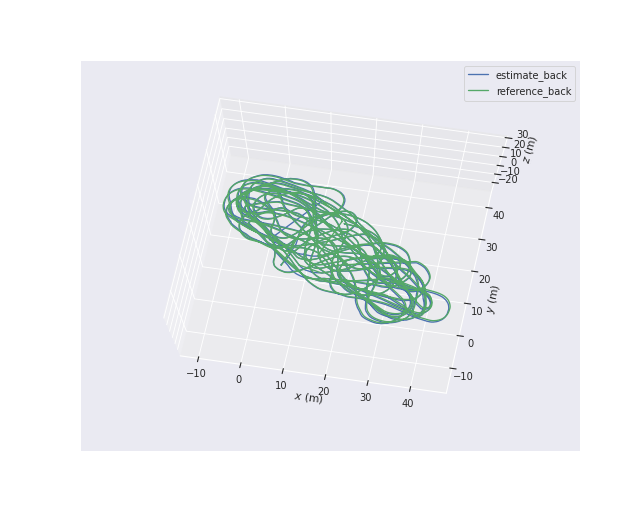

In [11]:
fig = plt.figure(figsize=(10,8))
traj_by_label = {
    #"estimate (not aligned)": traj_est,
    "estimate_back": traj_est_aligned_back,
    "reference_back": traj_ref_back,
    #"estimate_front": traj_est_aligned_front,
    #"reference_front": traj_ref_front,
    #"estimate_middle": traj_est_aligned_middle,
    #"reference_middle": traj_ref_middle
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)
plt.show()

In [4]:
pose_relation = metrics.PoseRelation.translation_part
use_aligned_trajectories = False

data_back = (traj_ref_back, traj_est_aligned_back) 
data_front = (traj_ref_front, traj_est_aligned_front) 
data_middle = (traj_ref_middle, traj_est_aligned_middle) 

ape_metric_back = metrics.APE(pose_relation)
ape_metric_back.process_data(data_back)
ape_metric_front = metrics.APE(pose_relation)
ape_metric_front.process_data(data_front)
ape_metric_middle = metrics.APE(pose_relation)
ape_metric_middle.process_data(data_middle)

ape_stat_back = ape_metric_back.get_statistic(metrics.StatisticsType.rmse)
ape_stat_front = ape_metric_front.get_statistic(metrics.StatisticsType.rmse)
ape_stat_middle = ape_metric_middle.get_statistic(metrics.StatisticsType.rmse)
print(ape_stat_back)
print(ape_stat_front)
print(ape_stat_middle)

5.075774985226663
5.072580665491712
5.07486537506596


<IPython.core.display.Javascript object>


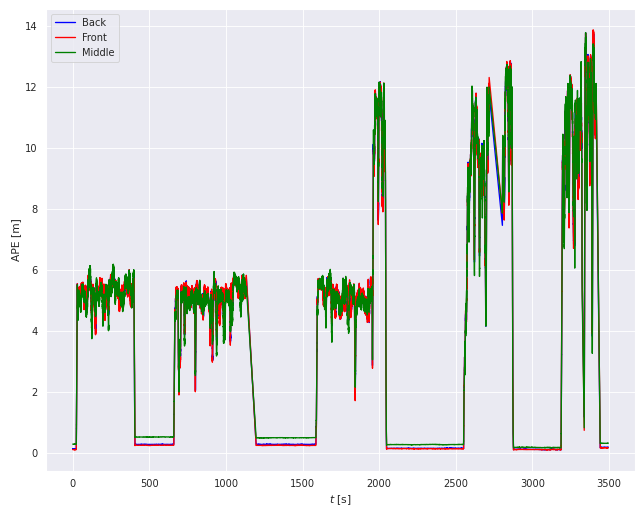

In [12]:
ape_stats_back = ape_metric_back.get_all_statistics()
#pprint.pprint(ape_stats_back)
ape_stats_front = ape_metric_front.get_all_statistics()
#pprint.pprint(ape_stats_front)
ape_stats_middle = ape_metric_middle.get_all_statistics()
#pprint.pprint(ape_stats_middle)

seconds_from_start_back = [t - traj_est_back.timestamps[0] for t in traj_est_back.timestamps]
seconds_from_start_front = [t - traj_est_front.timestamps[0] for t in traj_est_front.timestamps]
seconds_from_start_middle = [t - traj_est_middle.timestamps[0] for t in traj_est_middle.timestamps]
fig = plt.figure(figsize=(10,8))
#plt.subplot(311)
plot.error_array(fig.gca(), ape_metric_back.error, x_array=seconds_from_start_back,
                 name="Back", title="APE w.r.t. " + ape_metric_back.pose_relation.value, color="blue")
#plt.subplot(312)
plot.error_array(fig.gca(), ape_metric_front.error, x_array=seconds_from_start_front,
                 name="Front", color="red")
#plt.subplot(313)
plot.error_array(fig.gca(), ape_metric_middle.error, x_array=seconds_from_start_middle,
                 name="Middle", xlabel="$t$ [s]", ylabel="APE [m]", color="green")
fig.tight_layout()
#plt.savefig("./figs/error_gps_ape_20220314.jpg")
plt.show()

In [ ]:
print(len(ape_metric_front.error))
print(len(traj_est_back.positions_xyz))

In [ ]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib
cmap = plt.get_cmap('viridis')
levels = MaxNLocator(nbins=10).tick_values(ape_metric_back.error.min(), ape_metric_back.error.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
fig, ax = plt.subplots(nrows=1, figsize=(10,8))
#sc=ax.scatter(traj_est_back.positions_xyz[:,0], -traj_est_back.positions_xyz[:,1], c=ape_metric_back.error, cmap='viridis', 
#              alpha=0.4, norm=matplotlib.colors.LogNorm())
#sc=ax.scatter(traj_est_front.positions_xyz[:,0], -traj_est_front.positions_xyz[:,1], c=ape_metric_front.error, cmap='viridis', 
#              alpha=0.4, norm=matplotlib.colors.LogNorm())
sc=ax.scatter(traj_est_middle.positions_xyz[:,0], -traj_est_middle.positions_xyz[:,1], c=ape_metric_middle.error, cmap='viridis', 
              alpha=0.4, norm=matplotlib.colors.LogNorm())
plt.colorbar(sc, label="Ape error [m]")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
plt.savefig("./figs/error_gps_middle_20220314.jpg")
fig.tight_layout()

<IPython.core.display.Javascript object>


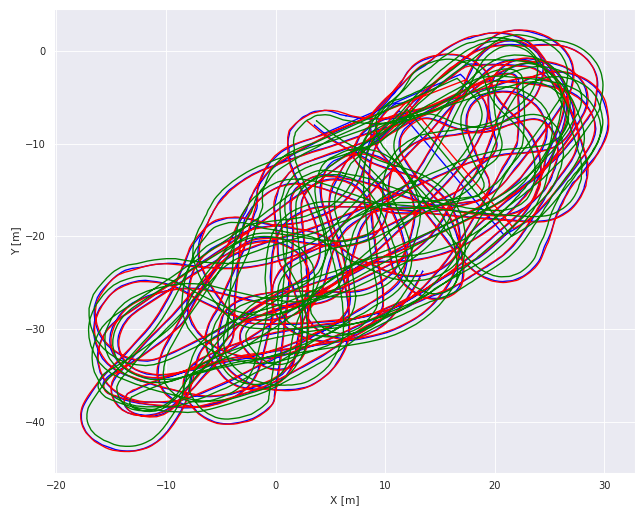

In [15]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib

fig, ax = plt.subplots(nrows=1, figsize=(10,8))
ax.plot(traj_est_back.positions_xyz[:,0], -traj_est_back.positions_xyz[:,1], color="blue")
ax.plot(traj_est_front.positions_xyz[:,0], -traj_est_front.positions_xyz[:,1], color="red")
ax.plot(traj_est_middle.positions_xyz[:,0], -traj_est_middle.positions_xyz[:,1], color="green")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
#plt.savefig("./figs/error_gps_middle_20220314.jpg")
fig.tight_layout()

In [ ]:
import importlib
import scripts.theodolite_utils as tfuu
tfuu = importlib.reload(tfuu)
output = "./data/error/error_ape_gps/20220427"
tfuu.Convert_gps_ape_error(traj_est_back, ape_metric_back.error, output+"ape_back.txt")
tfuu.Convert_gps_ape_error(traj_est_front, ape_metric_front.error, output+"ape_front.txt")
tfuu.Convert_gps_ape_error(traj_est_middle, ape_metric_middle.error, output+"ape_middle.txt")